# **Long notebook assignment**

<h1 align="center">Cognitive Commanders</h1>

<table>
    <tr>
        <td align="center">
            <strong>Petter Dalhaug (528276)</strong><br>
        </td>
        <td align="center">
            <strong>Mathias Otnes (563940)</strong><br>
        </td>
        <td align="center">
            <strong>Christoffer Roelofsen (544069)</strong><br>
        </td>
    </tr>
    <tr>
        <td>
            <img src="./assets/petter.png" width="100%" />
        </td>
        <td>
            <img src="./assets/mathias.png" width="100%" />
        </td>
        <td>
            <img src="./assets/christoffer.png" width="100%" />
        </td>
    </tr>
</table>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from catboost import CatBoostRegressor
from autogluon.tabular import TabularDataset, TabularPredictor
import warnings
warnings.filterwarnings('ignore')

# **Domain Knowledge**
After reading up on solar panel performance, there were som obvious factors that we could take advantage of based on our features. There were also some factors that would be more difficult for us to pick up on. For example panel maintanance and other non-weather related features would not be something we could get from our data. This was the most important factors based on the article referenced in the sources:

### **Radiation**

(PV) production is highly sensitive to the amount of accessible solar energy that falls directly on the module, with specific reference to a loss in efficiency when there is a deviation from the direct component of solar irradiation. This directly relates to solar radiation, indicating that optimal PV system performance is closely tied to receiving direct sunlight.

### **Sun alignment**

PV output is significantly affected by the alignment to the sun, with even minor deviations causing measurable efficiency losses.

### **Temperature**

PV module efficiency decreases as temperatures rise, emphasizing the need for cooling strategies.

### **Dust**

Dust accumulation on PV modules affects energy output over time, reducing transmittance and thus efficiency, if not regularly cleaned. Dust could also be related to wind, making that an interesting feature

### **Environmental factors**

The tilt angle of panels, local weather conditions like rain and wind speed, and environmental cleanliness are vital in maintaining or improving a module's performance.

### **Wind**

While wind can cool PV modules and improve efficiency, its effectiveness varies significantly with location and ambient temperature conditions.

### **Humidity**

Environments with high temperatures and humidity levels above 70% markedly decrease solar cell efficiency.


A lot of these factors outlined here are information we have in our features, and what is interesting is that the combination of some speficic features seem to be important based on the article. 


When it came to understanding how the data was generated, we didnt spend that much time investigating. This was not the most important information in our eyes. A simple question to chatgpt gave us this answer:

"The data for predicting solar energy production in a Kaggle competition is likely generated through a combination of observational measurements, weather modeling, and solar radiation simulations. Here's a brief overview of possible sources for each type of data:

1. **PV Measurement**: Actual recorded output from photovoltaic systems.
2. **Atmospheric Conditions**: 'Absolute_humidity_2m_gm3', 'air_density_2m_kgm3', 'dew_point_2m_K', 'msl_pressure_hPa', 'pressure_100m_hPa', 'pressure_50m_hPa', 'relative_humidity_1000hPa_p', 'sfc_pressure_hPa', 'visibility_m' are typically derived from weather stations and atmospheric models.
3. **Radiation Data**: 'Clear_sky_rad_W', 'diffuse_rad_W', 'direct_rad_W', 'diffuse_rad_1h_J', 'direct_rad_1h_J' could be obtained from satellite observations and radiative transfer models that estimate solar radiation reaching the ground.
4. **Cloud Cover**: 'Effective_cloud_cover_p', 'total_cloud_cover_p' might come from satellite imagery or weather forecast models.
5. **Elevation Data**: 'Elevation_m' is geographical data, which can influence the microclimate and sun exposure of the location.
6. **Sun Position**: 'Sun_azimuth_d', 'sun_elevation_d' are calculated based on the geographical location and time of the year.
7. **Wind Conditions**: 'Wind_speed_10m_ms', 'wind_speed_u_10m_ms', 'wind_speed_v_10m_ms' are obtained from meteorological models or local measurements.
8. **Snow Water Equivalent**: 'Snow_water_kgm2' indicates the water content in snow, measured via sensors or estimated through models.
9. **Temporal Data**: 'Month', 'year', 'time_of_day' are time stamps for the data points, crucial for correlating weather patterns with solar energy production.
10. **Shadowing and Daylight Index**: 'Is_day_idx', 'is_in_shadow_idx' indicate whether it's day and if the location is shadowed, which might be derived from sun position algorithms or local topographical data.

The datasets are often a hybrid of in situ measurements from ground weather stations, satellite data, and numerical weather prediction models."(GPT4, 2023)

The most intersting thing here are the geographical related features, which we could use to estimate where the data is from. After looking in to this we were pretty sure it was from Norway. 


sources:

 Jathar, L. D., Ganesan, S., Awasarmol, U., Nikam, K., Shahapurkar, K., Soudagar, M. E. M., Fayaz, H., El-Shafay, A. S., Kalam, M. A., Bouadila, S., Baddadi, S., Tirth, V., Nizami, A. S., Lam, S. S., & Rehan, M. (Year). Comprehensive review of environmental factors influencing the performance of photovoltaic panels: Concern over emissions at various phases throughout the lifecycle. Environmental Pollution, Volume 326. DOI or URL https://www.sciencedirect.com/science/article/pii/S0269749123004761?via%3Dihub#sec6

 OpenAI. (2023). ChatGPT-4 [Chatbot]. Available from https://chat.openai.com

# **EDA**

The first thing we did was to analyse the correlation between all the features and the target.
![Correlation](./assets/correlations.png)

After this, we went through all the features to see if we could spot any patterns. Note that some columns are engineered as this was an iterative process. This is one of many pairplots we went through for analysing. We went through all the features.

![Pairplot with solar columns](./assets/solar_columns.png)

## pv_columns

- `total_radiation` has a linear relationship with `pv_measurement`.
- `date_forecast_fft_amplitude` and `date_forecast_fft_phase` look pretty useless. 
- `total_radiation_rate_of_change` seems to not tell anything about `pv_measurement`.
- `total_radiation_rollinig_avg_3` is very similar to `total_radiation`, and keeping both would likelly lead to multicollinearity.

<strong>`total_radiation` is the only feature that should be kept, and further feature engineering is probaly not necessary</strong>

## snow_columns

- All the snow features have some negative correlation between with the `pv_measurement`. Most of them have mostly zeroes.
- `snow_accumulation` has good correlation with all snow features, and is a good representative to them all.

<strong>Use `snow_accumulation` as the only snow feature</strong>

## pressure_columns

- The values are very big, and looks like they're all constant for the different `pv_measurement` values, but normalizing these can propably lead so show some relation.

<strong>These features need some scaling</strong>

## cloud_columns

- `effective_cloud_cover:p` and `total_cloud_cover:p` has a very high correlation with eachother, but they seem random in relation to `pv_measurement`. These should be investigated to see if they can show a non-random pattern when combined with other features. 
- `cloud_base_agl:m` has a slightly negative correlation with `pv_measurement`, and not many relationships to other features. This should be investigated.
- `super_cooled_liquid_water:kgm2` has a negative correlation with `pv_measurement`, and slight positive correlation with `effective_cloud_cover:p` and `total_cloud_cover:p` which can hint of a relationship between cloud cover and when the liquid is used. Maybe this can be used to find a relationship between the seemingly random cloud covers and `pv_measurement`

<strong>Only one of `effective_cloud_cover:p` and `total_cloud_cover:p` should be used, but should be combined with other features to reveal a relationship. `cloud_base_agl:m` can maybe get used, but propably not the best feature without engineering. `super_cooled_liquid_water:kgm2` is a good feature. </strong>

## temperature_columns

- `t_1000hPa:K` and `dew_point_2m:K` may have a correlation with `pv_measurement`, but they need scaling in order to reveal this.
- `temp_dewpoint_diff` seems to have correlation with `pv_measurement`, but this can be just because the temperatures has been scaled because `t_1000hPa:K` and `dew_point_2m:K` have similar scales which leads their difference to be pretty standardized. The lagged feature `temp_dewpoint_diff_lag_-4` has high correlation with `temp_dewpoint_diff`, and only one should be kept. It's likelly that the lagged feature is artificially more correlated to `pv_measurement`, and should be removed. 
- `t_1000hPa:K_rate_of_change` seems to have a slight positive correlation to `pv_measurement`, and no correlation with other features, and should be kept, but some engineering for scaling is maybe necessary.
- `t_1000hPa:K` and `dew_point_2m:K` have some datapoints in 0 kelvin, which should be removed.

<strong>Scale the features `t_1000hPa:K_rate_of_change`, `t_1000hPa:K` and `dew_point_2m:K`. Remove 0 kelvin datapoints, and figure out if we need both `t_1000hPa:K` and `dew_point_2m:K` or if we should only choose one.</strong>

## humidity_columns

- Roughly all high values of `pv_measurment` is when `dew_or_rime:idx` is 0, and this can maybe be engineered a bit, it can maybe be used as a "filter" for high measurements. 
- `relative_humidity_1000hPa:p` and `absolute_humidity_1000hPa:p` doesn't have too much correlation, both can be kept, but `relative_humidity_1000hPa:p` may encode the temperature dependency, which can be more beneficial. The both seem to be uncorrelated to `pv_measurement`, but an implicit correlation should be searched for. 
- All features mulitplied with temperature is almost perfectly correlated with the original feature, be aware of this. Scale the temperature before making the interaction feature, or don't include the interaction features. 
- Rolling averages don't seem to have much effect.

<strong>Search for a combined feature including `relative_humidity_1000hPa:p` and/or `absolute_humidity_1000hPa:p` for revealing a implicit correlation.</strong>

## wind_columns

- All wind speed columns seems very correlated to `average_wind_speed`, which has the best correlation with `pv_measurement`.
- `wind_speed_w_1000hPa:ms` seems useless.
- `wind_vector_magnitude` is similar to `average_wind_speed` and correlated, but slightly less correlated to `pv_measurement`.

<strong>Only keep `average_wind_speed`.</strong>

## solar_columns (from picture)

- `sun_elevation:d` has a high correlation with `pv_measurement`. All the measurements are 0 when `sun_elevation:d` are 0 and less. Some engineering may be necessary, it whould have a lot of weight when the elevation is 0 or less, because it shouldn't be possible with positive `pv_measurments` without sun.
- `sun_azimuth:d` has a bell curve correlation with `pv_measurement`, and could maybe benefit from some engineering. It's a very clear pattern. It has similar correlation to a lot of the other radiation features.
- `sun_elevation:dfft_amplitude` seems bad, and has values close to infinity. 
- `sun_elevation:dfft_phase` has some strange patterns, but is seemingly random regarding `pv_measurement`, and should be dropped.
- `sun_elevation_rolling_avg_6` looses information about the measurement being 0 when there is no sun. It's very correlated with `sun_elevation:d`, and it should be removed. 
- `sun_elevation_direct_rad_interaction` seems very nicely correlated with `pv_measurement`. I would like to see what happens if `sun_elevation:d` is strictly positive before combining. This interaction feature should also be scaled down a bit, and it could possibly use `total_radiation` instead of `direct_rad:W`.
- `clear_sky_rad:W` is very correlated with `pv_measurement`, but also to `clear_sky_energy_1h:J`, and only one of them should be kept. It seems like it can't be larger than `direct_rad:W`, so maybe an interaction feature here could be interesting. 
- `direct_rad:W` and `direct_rad_1h:J` is very correlated, only one should be kept, but they have good correlation with `pv_measurement`.
- `direct_rad:W_rate_of_change` seems uncorrelated to `pv_measurement`.
- `diffuse_rad:W` seems somewhat uncorrelated to `direct_rad:W`, but very correlated to `pv_measurement`. It's very correlated to `diffuse_rad_1h:J`, and only one of them should be kept. 
- `diffuse_rad:W_rate_of_change` seems uncorrelated to `pv_measurement`.

<strong>Experimant with `sun_elevation:d` and `sun_azimuth`. Remove fft features and rolling averages. Experiment with interaction features with `sun_elevation:d`. Experiment with interaction between `clear_sky_energy_1h:J`, `clear_sky_rad:W` and other radiation features. Remove all rate of change features. Test what is best between `total_radiation` and having both `diffuse_rad:W` and `direct_rad:W`</strong>

## visibility_columns

- `visibility:m` seems uncorrelated to `pv_measurement`, but maybe it can be used as an interaction features.
- `ceiling_height_agl:m` seems to always be larger than `cloud_base_agl:m`, but both of them seem uncorrelated to pv_measurement. Maybe a boolean value can be extracted from these to indicate whether or not there is clouds.
- `is_day:idx` and `is_in_shadow:idx` has all the high `pv_measurement` values where you expect them, but it doesn't seem to provide a lot of info. Maybe it can be used in another feature.

<strong>Experiment with `visibility:m`, `ceiling_height_agl:m`, `cloud_base_agl:m`, `is_day:idx` and `is_in_shadow:idx`. They all seem useless on their own.</strong>

## precipitation_columns

- `rain_water:kgm2` seems correlated to `pv_measurement`, and should be explored. 
- `precip_5min:mm` seems similar to `rain_water:kgm2`, but with less information. It can maybe be combined with `precip_type_5min:idx` to reveal a correlation.
- The rest of the features doesn't seem to provide much info.

<strong>Explore the combination of `precip_5min:mm` and `precip_type_5min:idx`. Maybe try to include `rain_water:kgm2`.</strong>

## time_lagged_columns

<strong>These all seem to include artificial correlations, and should likelly not be included.</strong>

## miscellaneous_columns

- `elevation:m` has some measurements that deviates. What's the deal with that?
- `month` seems to show a clear trend, maybe some engineering to get the relationship to get caught by the model.
- `observed` is uncorrelated, but maybe it can be combined with another feature.

<strong>Investigate ways to empasize the relationship between `month` and `pv_measurement`. Maybe explore combinatied features with `observed`.</strong>

# **Multicollinearity**
Heatmap for finding correlation between columns. We aim to exclude columns that are very correlated with eachother because this may confuse the model on the underlying dependencies between the features and the target.
![Heatmap](./assets/heatmap.png)

# **Lagged features**

We also investigated all the features for potential lagged correlation with the target by checking the cross-correlation between all the features and the target. This is one of the lagged correlations we found between the target and pressure. It's plotted with a confidence-interval of 95%.
![Lagged pressure](./assets/lag.png)

# **Extra comments**

- elevation:m seemed to be constant on the different locations, and we chose to remove it. 
- Most of the data seemed intuitive, e.g when sun_elevation:d is less than 0, pv_measurement is 0. And pv_measurement is the most when the sun is at it's highest.

# **Preprocessing**

Our aggregation methods where found through experimentation, domain knowledge and by exploring correlations between the different parts of the hours and the target for the corresponding hour. The plot is hard to interpret so we left it out of the report. 

In [2]:
# Aggregate the data to hourly with some aggregation methods for each column

aggregation_methods = {
    'date_forecast': 'first',
    'diffuse_rad:W': 'sum',
    'direct_rad:W': 'last',
    'clear_sky_rad:W': 'sum',
    'diffuse_rad_1h:J': 'last',
    'direct_rad_1h:J': 'last',
    'clear_sky_energy_1h:J': 'last',
    'absolute_humidity_2m:gm3': 'mean',
    'air_density_2m:kgm3': 'mean',
    'ceiling_height_agl:m': 'max',
    'cloud_base_agl:m': 'mean',
    'dew_or_rime:idx': 'min',
    'dew_point_2m:K': 'mean',
    'effective_cloud_cover:p': 'sum',
    'elevation:m': 'first',
    'fresh_snow_12h:cm': 'max',
    'fresh_snow_1h:cm': 'sum',
    'fresh_snow_24h:cm': 'max',
    'fresh_snow_3h:cm': 'max',
    'fresh_snow_6h:cm': 'max',
    'is_day:idx': 'max',
    'is_in_shadow:idx': 'max',
    'msl_pressure:hPa': 'mean',
    'precip_5min:mm': 'sum',
    'precip_type_5min:idx': 'sum',
    'pressure_100m:hPa': 'mean',
    'pressure_50m:hPa': 'mean',
    'prob_rime:p': 'max',
    'rain_water:kgm2': 'sum',
    'relative_humidity_1000hPa:p': 'mean',
    'sfc_pressure:hPa': 'mean',
    'snow_density:kgm3': 'mean',
    'snow_depth:cm': 'max',
    'snow_drift:idx': 'max',
    'snow_melt_10min:mm': 'sum',
    'snow_water:kgm2': 'sum',
    'sun_azimuth:d': 'first',
    'sun_elevation:d': 'sum',
    'super_cooled_liquid_water:kgm2': 'sum',
    't_1000hPa:K': 'mean',
    'total_cloud_cover:p': 'mean',
    'visibility:m': 'mean',
    'wind_speed_10m:ms': 'mean',
    'wind_speed_u_10m:ms': 'mean',
    'wind_speed_v_10m:ms': 'mean',
    'wind_speed_w_1000hPa:ms': 'mean',
    'cloud_base_agl:m': 'max',
    'snow_density:kgm3': 'mean'
}


# Read in the data
x_target_A = pd.read_parquet('../../data/A/train_targets.parquet')
x_train_obs_A = pd.read_parquet('../../data/A/X_train_observed.parquet')
x_train_est_A = pd.read_parquet('../../data/A/X_train_estimated.parquet')
x_test_est_A = pd.read_parquet('../../data/A/X_test_estimated.parquet')

x_target_B = pd.read_parquet('../../data/B/train_targets.parquet')
x_train_obs_B = pd.read_parquet('../../data/B/X_train_observed.parquet')
x_train_est_B = pd.read_parquet('../../data/B/X_train_estimated.parquet')
x_test_est_B = pd.read_parquet('../../data/B/X_test_estimated.parquet')

x_target_C = pd.read_parquet('../../data/C/train_targets.parquet')
x_train_obs_C = pd.read_parquet('../../data/C/X_train_observed.parquet')
x_train_est_C = pd.read_parquet('../../data/C/X_train_estimated.parquet')
x_test_est_C = pd.read_parquet('../../data/C/X_test_estimated.parquet')

# Rename time to date_forecast in target
x_target_A.rename(columns={'time': 'date_forecast'}, inplace=True)
x_target_B.rename(columns={'time': 'date_forecast'}, inplace=True)
x_target_C.rename(columns={'time': 'date_forecast'}, inplace=True)

# Fix missing data for test set. Assumin NaN means 0 in these categories
x_test_est_A['effective_cloud_cover:p'] = x_test_est_A['effective_cloud_cover:p'].fillna(0)
x_test_est_B['effective_cloud_cover:p'] = x_test_est_B['effective_cloud_cover:p'].fillna(0)
x_test_est_C['effective_cloud_cover:p'] = x_test_est_C['effective_cloud_cover:p'].fillna(0)

x_test_est_A['total_cloud_cover:p'] = x_test_est_A['total_cloud_cover:p'].fillna(0)
x_test_est_B['total_cloud_cover:p'] = x_test_est_B['total_cloud_cover:p'].fillna(0)
x_test_est_C['total_cloud_cover:p'] = x_test_est_C['total_cloud_cover:p'].fillna(0)

x_test_est_A['cloud_base_agl:m'] = x_test_est_A['cloud_base_agl:m'].fillna(0)
x_test_est_B['cloud_base_agl:m'] = x_test_est_B['cloud_base_agl:m'].fillna(0)
x_test_est_C['cloud_base_agl:m'] = x_test_est_C['cloud_base_agl:m'].fillna(0)

x_test_est_A['ceiling_height_agl:m'] = x_test_est_A['ceiling_height_agl:m'].fillna(0)
x_test_est_B['ceiling_height_agl:m'] = x_test_est_B['ceiling_height_agl:m'].fillna(0)
x_test_est_C['ceiling_height_agl:m'] = x_test_est_C['ceiling_height_agl:m'].fillna(0)

x_test_est_A['snow_density:kgm3'] = x_test_est_A['snow_density:kgm3'].fillna(0)
x_test_est_B['snow_density:kgm3'] = x_test_est_B['snow_density:kgm3'].fillna(0)
x_test_est_C['snow_density:kgm3'] = x_test_est_C['snow_density:kgm3'].fillna(0)

x_test_est_A['snow_drift:idx'] = x_test_est_A['snow_drift:idx'].fillna(0)
x_test_est_B['snow_drift:idx'] = x_test_est_B['snow_drift:idx'].fillna(0)
x_test_est_C['snow_drift:idx'] = x_test_est_C['snow_drift:idx'].fillna(0)

# Resample
x_train_obs_A_resampled = x_train_obs_A.groupby(pd.Grouper(key='date_forecast', freq='1H')).aggregate(aggregation_methods)
x_train_est_A_resampled = x_train_est_A.groupby(pd.Grouper(key='date_forecast', freq='1H')).aggregate(aggregation_methods)
x_test_est_A_resampled = x_test_est_A.groupby(pd.Grouper(key='date_forecast', freq='1H')).aggregate(aggregation_methods)

x_train_obs_B_resampled = x_train_obs_B.groupby(pd.Grouper(key='date_forecast', freq='1H')).aggregate(aggregation_methods)
x_train_est_B_resampled = x_train_est_B.groupby(pd.Grouper(key='date_forecast', freq='1H')).aggregate(aggregation_methods)
x_test_est_B_resampled = x_test_est_B.groupby(pd.Grouper(key='date_forecast', freq='1H')).aggregate(aggregation_methods)

x_train_obs_C_resampled = x_train_obs_C.groupby(pd.Grouper(key='date_forecast', freq='1H')).aggregate(aggregation_methods)
x_train_est_C_resampled = x_train_est_C.groupby(pd.Grouper(key='date_forecast', freq='1H')).aggregate(aggregation_methods)
x_test_est_C_resampled = x_test_est_C.groupby(pd.Grouper(key='date_forecast', freq='1H')).aggregate(aggregation_methods)

# Merge
split_value = x_train_est_A['date_forecast'].iloc[0]
split_index = x_target_A[x_target_A['date_forecast'] == split_value].index[0]

x_target_obs_A = x_target_A.iloc[:split_index]
x_target_est_A = x_target_A.iloc[split_index:]

obs_A = x_train_obs_A_resampled.merge(x_target_obs_A, left_index=True, right_on='date_forecast')
est_A = x_train_est_A_resampled.merge(x_target_est_A, left_index=True, right_on='date_forecast')

split_value = x_train_est_B['date_forecast'].iloc[0]
split_index = x_target_B[x_target_B['date_forecast'] == split_value].index[0]

x_target_obs_B = x_target_B.iloc[:split_index]
x_target_est_B = x_target_B.iloc[split_index:]

obs_B = x_train_obs_B_resampled.merge(x_target_obs_B, left_index=True, right_on='date_forecast')
est_B = x_train_est_B_resampled.merge(x_target_est_B, left_index=True, right_on='date_forecast')

split_value = x_train_est_C['date_forecast'].iloc[0]
split_index = x_target_C[x_target_C['date_forecast'] == split_value].index[0]

x_target_obs_C = x_target_C.iloc[:split_index]
x_target_est_C = x_target_C.iloc[split_index:]

obs_C = x_train_obs_C_resampled.merge(x_target_obs_C, left_index=True, right_on='date_forecast')
est_C = x_train_est_C_resampled.merge(x_target_est_C, left_index=True, right_on='date_forecast')

# Keep date_forecast in test dfs
test_A = x_test_est_A_resampled
test_B = x_test_est_B_resampled
test_C = x_test_est_C_resampled

# Drop all the NaNs
test_A = test_A.dropna()
test_B = test_B.dropna()
test_C = test_C.dropna()

`add_experimental_features()` is a set of features with different combinations of features that we thought were smart based on domain knowledge and experimentation. Some of these has more correlation with the target than the base features such as `total_radiation:W`. We have also done some engineering based on the EDA from earlier such as using the temperature in Celsius instead of Kelvin. 

In [3]:
def add_experimental_features(df):
    """
    Experimental feature engineering.
    """

    # Radiation Features
    df['total_radiation:W'] = df['direct_rad:W'] + df['diffuse_rad:W']
    df['total_radiation_1h:J'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']
    df['rad_diff:W'] = df['direct_rad:W'] - df['diffuse_rad:W']
    df['rad_diff_1h:J'] = df['direct_rad_1h:J'] - df['diffuse_rad_1h:J']
    df['diffuse_direct_ratio'] = df['diffuse_rad:W'] / df['direct_rad:W']

    # Temperature and Pressure Features
    df['temp_dewpoint_diff'] = df['t_1000hPa:K'] - df['dew_point_2m:K']
    df['pressure_gradient'] = df['pressure_100m:hPa'] - df['pressure_50m:hPa']
    df['t_1000hPa:C'] = df['t_1000hPa:K'] - 273.15
    df['dew_point_2m:C'] = df['dew_point_2m:K'] - 273.15
    df['msl_pressure:hPa_scaled'] = MinMaxScaler().fit_transform(df['msl_pressure:hPa'].values.reshape(-1, 1))
    df['sfc_pressure:hPa_scaled'] = MinMaxScaler().fit_transform(df['sfc_pressure:hPa'].values.reshape(-1, 1))

    # Wind Features
    df['wind_vector_magnitude'] = (df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2 + df['wind_speed_w_1000hPa:ms']**2)**0.5
    df['average_wind_speed'] = (df['wind_speed_10m:ms'] + df['wind_speed_u_10m:ms']) / 2

    # Cloud and Snow Features
    df['cloud_humidity_product'] = df['total_cloud_cover:p'] * df['absolute_humidity_2m:gm3']
    df['snow_accumulation'] = df[['fresh_snow_24h:cm', 'fresh_snow_12h:cm', 'fresh_snow_6h:cm', 'fresh_snow_3h:cm', 'fresh_snow_1h:cm']].sum(axis=1)

    # Interaction between radiation and cloud cover
    df['radiation_cloud_interaction'] = df['direct_rad:W'] * df['effective_cloud_cover:p']

    # Interaction between temperature and radiation (considering that high temperature may reduce efficiency)
    df['temp_rad_interaction'] = df['t_1000hPa:K'] * df['total_radiation:W']

    # Interaction between wind cooling effect and temperature
    df['wind_temp_interaction'] = df['average_wind_speed'] * df['t_1000hPa:K']

    # Interaction between humidity and temperature
    df['humidity_temp_interaction'] = df['absolute_humidity_2m:gm3'] * df['t_1000hPa:K']

    # Interaction between humidity and radiation
    df['sun_elevation_direct_rad_interaction'] = df['sun_elevation:d'] * df['direct_rad:W']

    # Precipitation Features
    df['precip'] = df['precip_5min:mm']*df['precip_type_5min:idx']

    # Safeguard in case of inf values
    df.replace([np.inf, -np.inf], 0, inplace=True)
    
    return df

In [4]:
def add_date_features(df):
    """
    Adds 'month', 'year', 'hour' and 'day' columns to the dataframe based on the 'date_forecast' column.
    Also adds 'hour_sin' and 'hour_cos' columns for the hour of the day.
    """
    
    # Check if 'date_forecast' exists in the dataframe
    if 'date_forecast' in df.columns:
        # Convert the 'date_forecast' column to datetime format
        df['date_forecast'] = pd.to_datetime(df['date_forecast'])
        
        # Extract month, year, hour and day
        df['month'] = df['date_forecast'].dt.month
        df['year'] = df['date_forecast'].dt.year
        df['hour'] = df['date_forecast'].dt.hour
        df['day'] = df['date_forecast'].dt.day
        df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
        df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)

    else:
        print("Warning: 'date_forecast' column not found in the dataframe. No date features added.")
        return df  # Keep the 'date_forecast' column in the dataframe
    
    return df

In [5]:
# Adding discretized features for the continuous variables to help tree-based models

def bin_columns(dataframe, columns_to_bin, n_bins=5):
    """
    Bins the specified columns of the dataframe into equal-sized bins.
    
    Parameters:
    - dataframe: pd.DataFrame
    - columns_to_bin: list of strings, the names of the columns to bin
    - n_bins: int or dict, the number of bins for each column (if int, use the same number for all columns;
              if dict, specify individual numbers with column names as keys)
    
    Returns:
    - binned_dataframe: pd.DataFrame, the dataframe with the specified columns binned
    """
    binned_dataframe = dataframe.copy()
    
    for column in columns_to_bin:
        # Determine the number of bins for this column
        bins = n_bins if isinstance(n_bins, int) else n_bins.get(column, 5)
        
        # Create quantile-based bins
        binned_dataframe[f'binned_{column}'] = pd.qcut(
            binned_dataframe[column],
            q=bins,
            labels=False,
            duplicates='drop'
        )
        
    return binned_dataframe

def add_binned_features(df):
    columns_to_bin = [
        'super_cooled_liquid_water:kgm2',
        'ceiling_height_agl:m',
        'cloud_base_agl:m'
    ]

    # Bin the columns
    # df = bin_columns(df, columns_to_bin)
    df = bin_columns(df, ['effective_cloud_cover:p'], n_bins=2)
    df = bin_columns(df, ['ceiling_height_agl:m'], n_bins=3)
    df = bin_columns(df, ['average_wind_speed'], n_bins=5)

    return df

In [6]:
def add_rate_of_change_features(df, features, second_order=False):
    """
    Adds rate of change columns for specified features in the dataframe.
    Assumes the dataframe is time sorted. If second_order is True, it also adds the second order rate of change.
    """
    for feature in features:
        rate_column_name = feature + '_rate_of_change'
        df[rate_column_name] = df[feature].diff().fillna(0)  # Handle the first diff NaN if required
        
        if second_order:  # Check if second order difference is required
            second_order_column_name = feature + '_rate_of_change_of_change'
            df[second_order_column_name] = df[rate_column_name].diff().fillna(0)  # Second order difference

    return df

def add_rate_of_change_features_to_df(df):
    # Define the features for which to calculate rate of change
    features_to_diff = [
        't_1000hPa:K',
        'clear_sky_rad:W', 'diffuse_rad:W', 'direct_rad:W',
        'effective_cloud_cover:p', 'total_radiation:W'
    ]

    # Add rate of change features
    return add_rate_of_change_features(df, features_to_diff, second_order=False)

In [7]:
def add_est_obs_feature(df):
    """
    Adds a column to the dataframe that indicates whether the data is estimated or observed.
    """
    # Add the est_obs feature
    if 'date_calc' not in df.columns:
        # If 'date_calc' does not exist, create 'observed' column and set to 1
        df['observed'] = 1
        return df
    else:
        # If 'date_calc' exists, create a new column and set values to 0
        df['observed'] = 0
        return df.drop(columns=['date_calc'])

In [8]:
def remove_constant_regions(dataframe, column_name="pv_measurement", threshold=72):
    """
    Removes rows where the specified column has constant values for more than the given threshold.
    """
    
    # Check if the specified column exists in the dataframe
    if column_name not in dataframe.columns:
        print(f"Warning: '{column_name}' column not found in the dataframe. No rows removed.")
        return dataframe
    
    same_as_previous = dataframe[column_name].eq(dataframe[column_name].shift())
    group_ids = (~same_as_previous).cumsum()
    to_remove = group_ids[same_as_previous].value_counts() > threshold
    group_ids_to_remove = to_remove[to_remove].index
    
    # Drop entire rows that match the conditions
    return dataframe.drop(dataframe[group_ids.isin(group_ids_to_remove)].index)

In [9]:
def add_lagged_features(df, features_with__lags, fill_value=None):
    """
    Adds lagged columns for specified features in the dataframe with specific lag periods.
    'features_with_specific_lags' is a dictionary with features as keys and specific lag as values.
    'fill_value' is what to fill the NaNs with, after shifting.
    """
    for feature, specific_lag in features_with__lags.items():
        lag_column_name = f"{feature}_lag_{specific_lag}"
        df[lag_column_name] = df[feature].shift(specific_lag).fillna(fill_value)
    return df

def add_lagged_features_to_df(df):
    features_with_lags = {
        'total_radiation:W': 1,
        'total_radiation:W': -1,
        'rad_diff:W': 1,
        'rad_diff:W': -1,
        'total_radiation_1h:J': 1,
        'total_radiation_1h:J': -1
    }

    # Add lagged features for specific lags
    return add_lagged_features(df, features_with_lags, fill_value=0)

This function sets all nans to 0. We've explored with dropping nans completely, but filling nans with 0 provided better results. This shows that nan may often represents 0, which makes sense in columns such as `ceiling_height_agl:m` and `cloud_base_agl:m`. These had to be set to 0 in the test data before removing nans, because the test data had mostly nans in these features. 

In [10]:
def handle_nan(df):
    # Remove the rows where target is nan
    try:
        df = df[df['pv_measurement'].notna()]
    except KeyError:
        pass

    # Set all remaining nans to 0
    return df.fillna(0)

In [11]:
def preprocessing(df):
    df = add_experimental_features(df)
    df = add_date_features(df)
    df = add_binned_features(df)
    df = add_rate_of_change_features_to_df(df)
    df = add_est_obs_feature(df)
    df = remove_constant_regions(df)
    df = add_lagged_features_to_df(df)
    df = handle_nan(df)

    return df

# Preprocess
obs_A = preprocessing(obs_A)
est_A = preprocessing(est_A)
test_A = preprocessing(test_A)

obs_B = preprocessing(obs_B)
est_B = preprocessing(est_B)
test_B = preprocessing(test_B)

obs_C = preprocessing(obs_C)
est_C = preprocessing(est_C)
test_C = preprocessing(test_C)

In [12]:
# Inpspect the data
print(obs_A.shape)
print(est_A.shape)
print(test_A.shape)


(29667, 89)
(4418, 89)
(720, 86)


In [13]:
# Random seeds used for reproducibility
# 32 weights: 0.3, 0.3, 0.4
# 24 weights: 0.3, 0.3, 0.4
# 33 (without winter months 1 and 12) weights: 0.2, 0.4, 0.4
# 11 (without winter months 1, 2 and 11, 12) weights: 0.25, 0.35, 0.4
# 5 weights: 0.4, 0.3, 0.3

# Best score is the mean prediction of all the 5 seeds mentioned above. The first weight is xgboost, the second is catboost, and the third is autogluon.

# Set the random seed
np.random.seed(4)

# Concatinate
A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

# Remove characters unparseable for CatBoost 
A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in A.columns]
B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in B.columns]
C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in C.columns]

test_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_A.columns]
test_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_B.columns]
test_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_C.columns]

# Getting validation data from summer months, because the test set is from summer months. We experimentet with excluding winter months
# from the training data here.

# Step 1: Filter A to include only months from March to October
A = A[A['date_forecast'].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])]

# Step 2: Identify unique days within May, June, and July
summer_months = A[A['date_forecast'].dt.month.isin([5, 6])]
unique_summer_days = summer_months['date_forecast'].dt.date.unique()

# Step 3: Sample these days for val_A
sampled_days = np.random.choice(unique_summer_days, size=int(len(unique_summer_days) * 0.4), replace=False)
val_A = A[A['date_forecast'].dt.date.isin(sampled_days)]

# Step 4: Define train_A as the remaining data
train_A = A[~A['date_forecast'].dt.date.isin(sampled_days)]

# Prepare your features and target variables
X_train_A = train_A.drop(columns='pv_measurement')
y_train_A = train_A['pv_measurement']
X_val_A = val_A.drop(columns='pv_measurement')
y_val_A = val_A['pv_measurement']

# Repeat for B and C
B = B[B['date_forecast'].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])]
summer_months = B[B['date_forecast'].dt.month.isin([5, 6])]
unique_summer_days = summer_months['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_summer_days, size=int(len(unique_summer_days) * 0.4), replace=False)
val_B = B[B['date_forecast'].dt.date.isin(sampled_days)]
train_B = B[~B['date_forecast'].dt.date.isin(sampled_days)]
X_train_B = train_B.drop(columns='pv_measurement')
y_train_B = train_B['pv_measurement']
X_val_B = val_B.drop(columns='pv_measurement')
y_val_B = val_B['pv_measurement']

C = C[C['date_forecast'].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])]
summer_months = C[C['date_forecast'].dt.month.isin([5, 6])]
unique_summer_days = summer_months['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_summer_days, size=int(len(unique_summer_days) * 0.4), replace=False)
val_C = C[C['date_forecast'].dt.date.isin(sampled_days)]
train_C = C[~C['date_forecast'].dt.date.isin(sampled_days)]
X_train_C = train_C.drop(columns='pv_measurement')
y_train_C = train_C['pv_measurement']
X_val_C = val_C.drop(columns='pv_measurement')
y_val_C = val_C['pv_measurement']

# Drop date_forecast
train_A = train_A.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
train_B = train_B.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
train_C = train_C.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
val_A = val_A.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
val_B = val_B.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
val_C = val_C.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_train_A = X_train_A.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_train_B = X_train_B.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_train_C = X_train_C.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_val_A = X_val_A.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_val_B = X_val_B.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
X_val_C = X_val_C.drop(columns=['date_forecast', 'date_forecast_x', 'date_forecast_y'])
test_A = test_A.drop(columns=['date_forecast'])
test_B = test_B.drop(columns=['date_forecast'])
test_C = test_C.drop(columns=['date_forecast'])

In [14]:
# Inspect test train split
print(test_A.shape)
print(train_A.shape)

(720, 85)
(32069, 86)


# **Model parameter tuning**

We used gridsearch on XGBoost for obtaining these parameters with the same train-test split. Autogluon tunes itself according to the tuning data (which is our summer validation data). We used default parameters for CatBoost, and LightGBM was used a lot in the beginning, but we dropped it as it lead to worse predictions. AutoGluon has multiple presets, but all other presets than "medium_quality" seemed to overfit. 

In [15]:
train_lgbm_A = lgb.Dataset(X_train_A, label=y_train_A)
val_lgbm_A = lgb.Dataset(X_val_A, label=y_val_A, reference=train_lgbm_A)

train_lgbm_B = lgb.Dataset(X_train_B, label=y_train_B)
val_lgbm_B = lgb.Dataset(X_val_B, label=y_val_B, reference=train_lgbm_B)

train_lgbm_C = lgb.Dataset(X_train_C, label=y_train_C)
val_lgbm_C = lgb.Dataset(X_val_C, label=y_val_C, reference=train_lgbm_C)

train_auto_A = TabularDataset(train_A)
val_auto_A = TabularDataset(val_A)

train_auto_B = TabularDataset(train_B)
val_auto_B = TabularDataset(val_B)

train_auto_C = TabularDataset(train_C)
val_auto_C = TabularDataset(val_C)

auto_label = 'pv_measurement'

# Set the parameters for the LGBM models
params_lgbm = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'verbose': 1
}

# Set the parameters for the XGBoost models
params_xgb_A = {
    'colsample_bytree': 0.8, 
    'gamma': 0.4, 
    'learning_rate': 0.012, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 0.8, 
    'reg_lambda': 0.8, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'num_parallel_tree': 2
}

params_xgb_B = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1
}

params_xgb_C = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1
}

xgb_A = xgb.XGBRegressor(**params_xgb_A)
xgb_B = xgb.XGBRegressor(**params_xgb_B)
xgb_C = xgb.XGBRegressor(**params_xgb_C)

cat_A = CatBoostRegressor(
    iterations=5000,         # The number of trees to build
    #learning_rate=0.09,     # The learning rate
    #depth=10,               # Depth of the tree
    loss_function='MAE',     # Loss function to be optimized. RMSE is common for regression.
    eval_metric='MAE',       # Evaluation metric for the validation set
    #random_seed=42,         # Seed for reproducibility
    #verbose=100             # Frequency of logging the training process
)

cat_B = CatBoostRegressor(
    iterations=5000,
    #learning_rate=0.09,
    #depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    #random_seed=42,
    #verbose=100
)

cat_C = CatBoostRegressor(
    iterations=5000,
    #learning_rate=0.09,
    #depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    #random_seed=42,
    #verbose=100
)


# **Model fitting**

In [16]:
# Train the LGBM models

lgbm_A = lgb.train(params_lgbm,
                train_lgbm_A,
                num_boost_round=1000,
                valid_sets=[val_lgbm_A],
                early_stopping_rounds=50,
                verbose_eval=50)

lgbm_B = lgb.train(params_lgbm,
                train_lgbm_B,
                num_boost_round=1000,
                valid_sets=[val_lgbm_B],
                early_stopping_rounds=50,
                verbose_eval=50)

lgbm_C = lgb.train(params_lgbm,
                train_lgbm_C,
                num_boost_round=1000,
                valid_sets=[val_lgbm_C],
                early_stopping_rounds=50,
                verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14990
[LightGBM] [Info] Number of data points in the train set: 32069, number of used features: 82
[LightGBM] [Info] Start training from score 591.953782
[50]	valid_0's l1: 466.199
[100]	valid_0's l1: 423.488
[150]	valid_0's l1: 401.908
[200]	valid_0's l1: 371.704
[250]	valid_0's l1: 358.357
[300]	valid_0's l1: 356.056
[350]	valid_0's l1: 355.04
[400]	valid_0's l1: 347.611
[450]	valid_0's l1: 345.504
[500]	valid_0's l1: 345.968
[550]	valid_0's l1: 346.526
[600]	valid_0's l1: 351.388
[650]	valid_0's l1: 347.151
[700]	valid_0's l1: 346.151
[750]	valid_0's l1: 346.35
[800]	valid_0's l1: 347.428
[850]	valid_0's l1: 345.472
[900]	valid_0's l1: 345.146
[950]	valid_0's l1: 345.009
[1000]	valid_0's l1: 344.997
[LightGBM] [Warning] Auto-choo

In [17]:
# Prepare data for the XGBoost models. We got them to work the best when having fewer columns
xgb_columns = [
    'total_radiationW',
    'snow_accumulation',
    'super_cooled_liquid_waterkgm2',
    'average_wind_speed',
    'sun_elevationd',
    'sun_azimuthd',
    'clear_sky_radW',
    'month',
    't_1000hPaC',
    'msl_pressurehPa_scaled',
    'rain_waterkgm2',
    'cloud_base_aglm',
    'effective_cloud_coverp',
    'dew_or_rimeidx'
]
print(train_A.columns)

X_train_xgb_A = train_A[xgb_columns]
y_train_xgb_A = train_A['pv_measurement']
X_test_xgb_A = test_A[xgb_columns]

X_train_xgb_B = train_B[xgb_columns]
y_train_xgb_B = train_B['pv_measurement']
X_test_xgb_B = test_B[xgb_columns]

X_train_xgb_C = train_C[xgb_columns]
y_train_xgb_C = train_C['pv_measurement']
X_test_xgb_C = test_C[xgb_columns]

# Train the XGBoost models
xgb_A.fit(
    X=X_train_xgb_A, y=y_train_xgb_A,
    eval_metric='mae',
    verbose=False
)

xgb_B.fit(
    X=X_train_xgb_B, y=y_train_xgb_B,
    eval_metric='mae',
    verbose=False
)

xgb_C.fit(
    X=X_train_xgb_C, y=y_train_xgb_C,
    eval_metric='mae',
    verbose=False
)

Index(['diffuse_radW', 'direct_radW', 'clear_sky_radW', 'diffuse_rad_1hJ',
       'direct_rad_1hJ', 'clear_sky_energy_1hJ', 'absolute_humidity_2mgm3',
       'air_density_2mkgm3', 'ceiling_height_aglm', 'cloud_base_aglm',
       'dew_or_rimeidx', 'dew_point_2mK', 'effective_cloud_coverp',
       'elevationm', 'fresh_snow_12hcm', 'fresh_snow_1hcm', 'fresh_snow_24hcm',
       'fresh_snow_3hcm', 'fresh_snow_6hcm', 'is_dayidx', 'is_in_shadowidx',
       'msl_pressurehPa', 'precip_5minmm', 'precip_type_5minidx',
       'pressure_100mhPa', 'pressure_50mhPa', 'prob_rimep', 'rain_waterkgm2',
       'relative_humidity_1000hPap', 'sfc_pressurehPa', 'snow_densitykgm3',
       'snow_depthcm', 'snow_driftidx', 'snow_melt_10minmm', 'snow_waterkgm2',
       'sun_azimuthd', 'sun_elevationd', 'super_cooled_liquid_waterkgm2',
       't_1000hPaK', 'total_cloud_coverp', 'visibilitym', 'wind_speed_10mms',
       'wind_speed_u_10mms', 'wind_speed_v_10mms', 'wind_speed_w_1000hPams',
       'pv_measurement', 

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.8, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [18]:
# Train the CatBoost models
cat_A.fit(
    X_train_A, y_train_A,
    eval_set=(X_val_A, y_val_A),
    use_best_model=True
)

cat_B.fit(
    X_train_B, y_train_B,
    eval_set=(X_val_B, y_val_B),
    use_best_model=True
)

cat_C.fit(
    X_train_C, y_train_C,
    eval_set=(X_val_C, y_val_C),
    use_best_model=True
)

0:	learn: 578.0162235	test: 1218.3892047	best: 1218.3892047 (0)	total: 64.5ms	remaining: 5m 22s
1:	learn: 566.7102630	test: 1195.2203169	best: 1195.2203169 (1)	total: 75.2ms	remaining: 3m 7s
2:	learn: 552.3220001	test: 1164.5349248	best: 1164.5349248 (2)	total: 87.9ms	remaining: 2m 26s
3:	learn: 540.1613897	test: 1142.3250071	best: 1142.3250071 (3)	total: 110ms	remaining: 2m 17s
4:	learn: 527.5864343	test: 1118.5306070	best: 1118.5306070 (4)	total: 125ms	remaining: 2m 5s
5:	learn: 514.1566668	test: 1090.2806744	best: 1090.2806744 (5)	total: 138ms	remaining: 1m 54s
6:	learn: 505.0423570	test: 1073.5218645	best: 1073.5218645 (6)	total: 145ms	remaining: 1m 43s
7:	learn: 495.5660580	test: 1052.1394395	best: 1052.1394395 (7)	total: 154ms	remaining: 1m 36s
8:	learn: 485.8213797	test: 1033.6131023	best: 1033.6131023 (8)	total: 161ms	remaining: 1m 29s
9:	learn: 474.2064313	test: 1009.7730601	best: 1009.7730601 (9)	total: 170ms	remaining: 1m 24s
10:	learn: 464.1171769	test: 988.8160516	best: 98

In [19]:
auto_A = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error', problem_type='regression').fit(train_auto_A, 
                                                                                   presets='medium_quality', 
                                                                                   tuning_data=val_auto_A, 
                                                                                   use_bag_holdout=True, 
                                                                                   ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'})
auto_A.plot_ensemble_model()

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_125838/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231112_125838/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:23 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T6000
Disk Space Avail:   20.19 GB / 494.38 GB (4.1%)
Train Data Rows:    32069
Train Data Columns: 85
Tuning Data Rows:    2016
Tuning Data Columns: 85
Label Column: pv_measurement
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5957.34 MB
	Train Data (Original)  Memory Usage: 12.41 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features

'AutogluonModels/ag-20231112_125838/ensemble_model.png'

In [20]:
auto_B = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error', problem_type='regression').fit(train_auto_B,
                                                                                      presets='medium_quality',
                                                                                      tuning_data=val_auto_B,
                                                                                      use_bag_holdout=True,
                                                                                      ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'})
auto_B.plot_ensemble_model()

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_130039/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231112_130039/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:23 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T6000
Disk Space Avail:   19.34 GB / 494.38 GB (3.9%)
Train Data Rows:    25786
Train Data Columns: 85
Tuning Data Rows:    1752
Tuning Data Columns: 85
Label Column: pv_measurement
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5846.97 MB
	Train Data (Original)  Memory Usage: 10.02 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features

'AutogluonModels/ag-20231112_130039/ensemble_model.png'

In [21]:
auto_C = TabularPredictor(label=auto_label, eval_metric='mean_absolute_error', problem_type='regression').fit(train_auto_C,
                                                                                        presets='medium_quality',
                                                                                        tuning_data=val_auto_C,
                                                                                        use_bag_holdout=True,
                                                                                        ag_args_ensemble={'fold_fitting_strategy': 'sequential_local'})
auto_C.plot_ensemble_model()

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_130209/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231112_130209/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:23 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T6000
Disk Space Avail:   18.75 GB / 494.38 GB (3.8%)
Train Data Rows:    21002
Train Data Columns: 85
Tuning Data Rows:    1152
Tuning Data Columns: 85
Label Column: pv_measurement
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5868.41 MB
	Train Data (Original)  Memory Usage: 8.06 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.

'AutogluonModels/ag-20231112_130209/ensemble_model.png'

In [22]:
# XGBoost is trained on the validation set as well on the submission, and is therefore
# excluded from this ensemble because this is for model interpretation purposes only

# Predictions
y_pred_lgbm_A = lgbm_A.predict(X_val_A, num_iteration=lgbm_A.best_iteration)
y_pred_lgbm_B = lgbm_B.predict(X_val_B, num_iteration=lgbm_B.best_iteration)
y_pred_lgbm_C = lgbm_C.predict(X_val_C, num_iteration=lgbm_C.best_iteration)

y_pred_xgb_A = xgb_A.predict(X_test_xgb_A)
y_pred_xgb_B = xgb_B.predict(X_test_xgb_B)
y_pred_xgb_C = xgb_C.predict(X_test_xgb_C)

y_pred_cat_A = cat_A.predict(X_val_A)
y_pred_cat_B = cat_B.predict(X_val_B)
y_pred_cat_C = cat_C.predict(X_val_C)

y_pred_auto_A = auto_A.predict(val_auto_A)
y_pred_auto_B = auto_B.predict(val_auto_B)
y_pred_auto_C = auto_C.predict(val_auto_C)

y_pred_A = (y_pred_lgbm_A + y_pred_cat_A + y_pred_auto_A) / 3
y_pred_B = (y_pred_lgbm_B + y_pred_cat_B + y_pred_auto_B) / 3
y_pred_C = (y_pred_lgbm_C + y_pred_cat_C + y_pred_auto_C) / 3

# **Model interpretation**
We saw that individual models seemed to generally guess too low or too high, and decided to ensemble them to get a better average guess. \
\
We tried to make the models compensate for eachothers misses by ensembling models in a way that makes the mean error get as close to 0 as possible and the mean absolute error be as low as possible to minimize variance. To to this, we tried to minimize the correlation between our models while increasing the correlation with the target, and stacking these to make the mean error close to 0. 

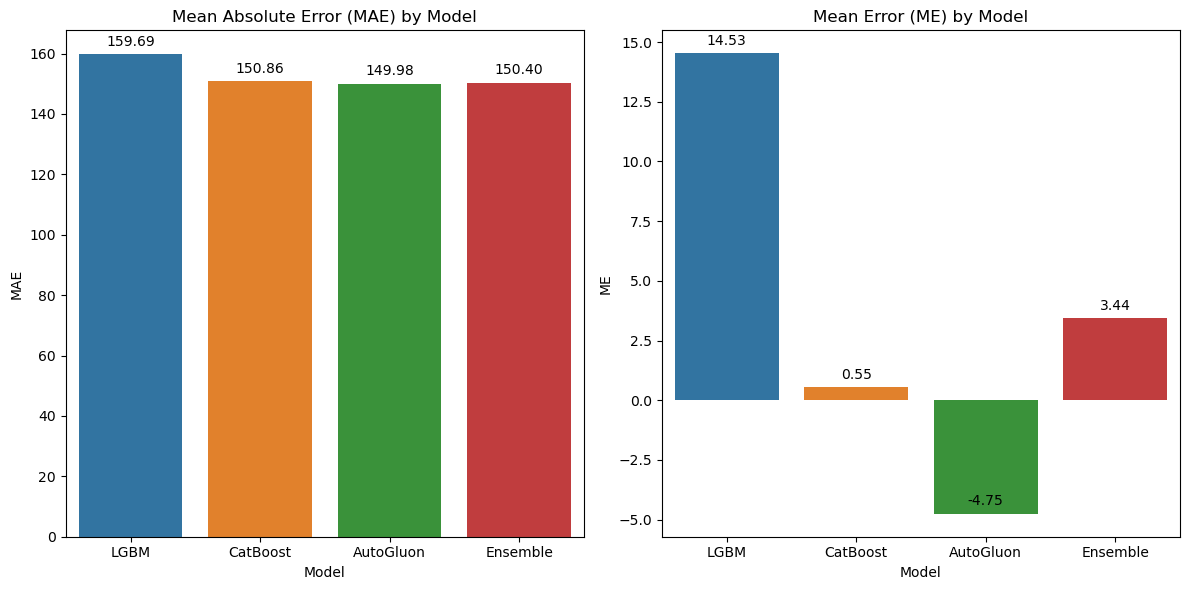

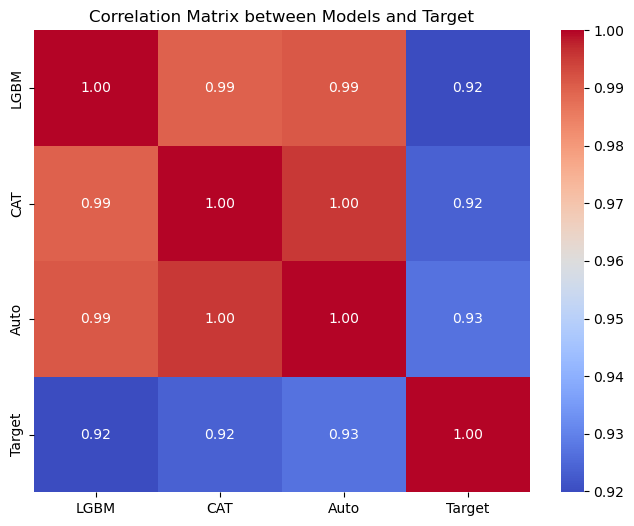

In [23]:
# Evaluate the models
mae_lgbm = (mean_absolute_error(y_val_A, y_pred_lgbm_A) + mean_absolute_error(y_val_B, y_pred_lgbm_B) + mean_absolute_error(y_val_C, y_pred_lgbm_C)) / 3
me_lgbm = (np.mean(y_val_A - y_pred_lgbm_A) + np.mean(y_val_B - y_pred_lgbm_B) + np.mean(y_val_C - y_pred_lgbm_C)) / 3

# mae_xgb = (mean_absolute_error(y_val_A, y_pred_xgb_A) + mean_absolute_error(y_val_B, y_pred_xgb_B) + mean_absolute_error(y_val_C, y_pred_xgb_C)) / 3
# me_xgb = (np.mean(y_val_A - y_pred_xgb_A) + np.mean(y_val_B - y_pred_xgb_B) + np.mean(y_val_C - y_pred_xgb_C)) / 3

mae_cat = (mean_absolute_error(y_val_A, y_pred_cat_A) + mean_absolute_error(y_val_B, y_pred_cat_B) + mean_absolute_error(y_val_C, y_pred_cat_C)) / 3
me_cat = (np.mean(y_val_A - y_pred_cat_A) + np.mean(y_val_B - y_pred_cat_B) + np.mean(y_val_C - y_pred_cat_C)) / 3

mae_auto = (mean_absolute_error(y_val_A, y_pred_auto_A) + mean_absolute_error(y_val_B, y_pred_auto_B) + mean_absolute_error(y_val_C, y_pred_auto_C)) / 3
me_auto = (np.mean(y_val_A - y_pred_auto_A) + np.mean(y_val_B - y_pred_auto_B) + np.mean(y_val_C - y_pred_auto_C)) / 3

mae_ensemble = (mean_absolute_error(y_val_A, y_pred_A) + mean_absolute_error(y_val_B, y_pred_B) + mean_absolute_error(y_val_C, y_pred_C)) / 3
me_ensemble = (np.mean(y_val_A - y_pred_A) + np.mean(y_val_B - y_pred_B) + np.mean(y_val_C - y_pred_C)) / 3


metric_data = {
    'Model': ['LGBM', 'CatBoost', 'AutoGluon', 'Ensemble'],
    'MAE': [mae_lgbm, mae_cat, mae_auto, mae_ensemble],
    'ME': [me_lgbm, me_cat, me_auto, me_ensemble]
}
df = pd.DataFrame(metric_data)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# MAE Plot
mae_barplot = sns.barplot(x='Model', y='MAE', data=df, ax=ax[0])
ax[0].set_title('Mean Absolute Error (MAE) by Model')
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('Model')

# Annotate MAE values
for p in mae_barplot.patches:
    mae_barplot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# ME Plot
me_barplot = sns.barplot(x='Model', y='ME', data=df, ax=ax[1])
ax[1].set_title('Mean Error (ME) by Model')
ax[1].set_ylabel('ME')
ax[1].set_xlabel('Model')

# Annotate ME values
for p in me_barplot.patches:
    me_barplot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Correlation between models
predictions = {
    'LGBM': y_pred_lgbm_A,
    'CAT': y_pred_cat_A,
    'Auto': y_pred_auto_A,
    'Target': y_val_A
}

df = pd.DataFrame(predictions)

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between Models and Target")
plt.show()

# **Feature Selection**
AutoGluon and CatBoost seemed to perform the best when they got as many features as possible, but we needed only the best features for XGBoost. Initially we added all the features we believed to be important from our EDA, and some that we thought that may could be important. Then we selected the final features through many rounds of selection using feature importance, and sequential feature selection. \
\
The sequential feature selection took too long to run to include in the notebook, but we did both forward, and backward feature selection. We tok the union of these feature selection methods and used for our final feature set.

In [24]:
# Feature importance
feature_importances = xgb_A.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X_train_xgb_A.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

# Print feature importance
for i in range(feature_importances.shape[0]):
    print(f"{i} {feature_importances.iloc[i, 0]}: {feature_importances.iloc[i, 1]}")

0 total_radiationW: 0.47948557138442993
1 clear_sky_radW: 0.2271229326725006
2 effective_cloud_coverp: 0.07765267044305801
3 rain_waterkgm2: 0.044321417808532715
4 sun_elevationd: 0.02707318216562271
5 month: 0.024111198261380196
6 snow_accumulation: 0.021990492939949036
7 cloud_base_aglm: 0.0196134764701128
8 sun_azimuthd: 0.017516912892460823
9 super_cooled_liquid_waterkgm2: 0.016005007550120354
10 msl_pressurehPa_scaled: 0.015378879383206367
11 t_1000hPaC: 0.014836248941719532
12 average_wind_speed: 0.014771427027881145
13 dew_or_rimeidx: 0.00012059956497978419


In [25]:
# Experimenting with ensembling different models from the leaderboard. WeighetEnsemle seemed to work the best.
auto_A.leaderboard()

                  model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -322.607369       0.191310  63.276244                0.000185           0.087210            2       True         12
1        NeuralNetTorch -331.208530       0.021697  11.088603                0.021697          11.088603            1       True         10
2         ExtraTreesMSE -336.910716       0.037633   8.646026                0.037633           8.646026            1       True          7
3            LightGBMXT -338.617911       0.006054   4.217309                0.006054           4.217309            1       True          3
4              CatBoost -341.117633       0.002936   3.432968                0.002936           3.432968            1       True          6
5         LightGBMLarge -341.868095       0.012051  20.802518                0.012051          20.802518            1       True         11
6       NeuralNetFas

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-322.607369,0.191310,63.276244,0.000185,0.087210,2,True,12
1,NeuralNetTorch,-331.208530,0.021697,11.088603,0.021697,11.088603,1,True,10
2,ExtraTreesMSE,-336.910716,0.037633,8.646026,0.037633,8.646026,1,True,7
3,LightGBMXT,-338.617911,0.006054,4.217309,0.006054,4.217309,1,True,3
4,CatBoost,-341.117633,0.002936,3.432968,0.002936,3.432968,1,True,6
5,LightGBMLarge,-341.868095,0.012051,20.802518,0.012051,20.802518,1,True,11
6,NeuralNetFastAI,-343.265313,0.015085,19.539350,0.015085,19.539350,1,True,8
7,RandomForestMSE,-343.282992,0.042104,44.044491,0.042104,44.044491,1,True,5
8,XGBoost,-343.953103,0.013205,3.086283,0.013205,3.086283,1,True,9
9,LightGBM,-344.527646,0.005137,3.605304,0.005137,3.605304,1,True,4


In [26]:
# Create submission

xgb_weight = 0.4
cat_weight = 0.3
auto_weight = 0.3

output_file = 'submission.csv'

print(test_A.shape)
print(train_A.shape)

pred_xgb_A = xgb_A.predict(X_test_xgb_C)
pred_xgb_B = xgb_B.predict(X_test_xgb_C)
pred_xgb_C = xgb_C.predict(X_test_xgb_C)

pred_auto_A = auto_A.predict(test_A)
pred_auto_B = auto_B.predict(test_B)
pred_auto_C = auto_C.predict(test_C)

pred_cat_A = cat_A.predict(test_A)
pred_cat_B = cat_B.predict(test_B)
pred_cat_C = cat_C.predict(test_C)

# Ensemble that seemed the best after some experimentation
pred_A = (pred_xgb_A*xgb_weight + pred_cat_A*cat_weight + pred_auto_A*auto_weight)
pred_B = (pred_xgb_B*xgb_weight + pred_cat_B*cat_weight + pred_auto_B*auto_weight)
pred_C = (pred_xgb_C*xgb_weight + pred_cat_C*cat_weight + pred_auto_C*auto_weight)

pred_A = np.clip(pred_A, 0, None)
pred_B = np.clip(pred_B, 0, None)
pred_C = np.clip(pred_C, 0, None)

# Concatenate predictions
predictions = np.concatenate([pred_A, pred_B, pred_C])

# Create an id array
ids = np.arange(0, len(predictions))

# Create a DataFrame
df = pd.DataFrame({
    'id': ids,
    'prediction': predictions
})

# Save to CSV
df.to_csv(output_file, index=False)
print(f"Submission saved to {output_file}")

(720, 85)
(32069, 86)
Submission saved to submission.csv
